In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk
from astropy.wcs import WCS

In [78]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=11, 
    width=11, 
    do_pca=True, 
    do_psf=False,
    time_arr=time, 
    data_arr=tpfs, 
    err_arr=errs, 
    bkg_arr=bkgs, 
)

photometry_flux = sc.to_lightcurve().flux[sq][start:end]
data.psf_lightcurve(flux_arr=photometry_flux.value, bkg_mag_cutoff=10, verbose=True)

plt.plot(time.mjd, photometry_flux / np.max(photometry_flux), label='aperture photometry')
plt.plot(time.mjd, data.psf_flux[:end-start] / np.max(data.psf_flux[:end-start]), label='psf fit')
plt.legend()
plt.show()


TypeError: 'NoneType' object is not subscriptable

In [76]:
data.user_given

False

In [181]:
mean_xs, mean_ys = 0, 0
base_background_tpf = np.mean(bkgs, axis=0)
def psf_deltas(mag):
    """Ideal TPF given a known/fitted PSF for a particular cadence."""
    # TODO update base_background_tpf with better background star fits
    return base_background_tpf + model(mag, xc[1]+mean_xs, yc[1]+mean_ys, mean_pars.x[-3:])

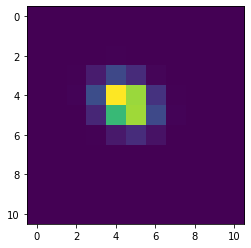

In [189]:
plt.imshow(psf_deltas(photometry_flux.value[600]))

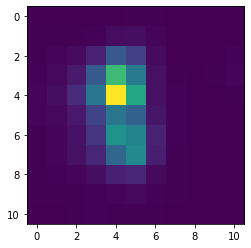

In [190]:
plt.imshow(np.mean(tpfs, axis=0))

In [180]:
xc, yc

([4.9, 4.5, 4.7], [3.0, 4.4, 7.0])

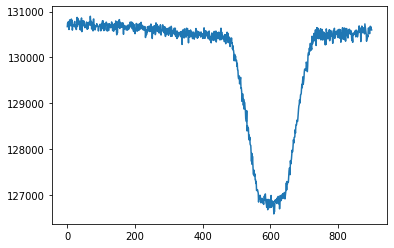

In [144]:
plt.plot([np.nansum(tpf * (sc.hdu[2].data & 4 == 0)) for tpf in tpfs])

In [156]:
data = eleanor.TargetData(
    star, 
    height=15, 
    width=15, 
    do_pca=True, 
    do_psf=False,
)

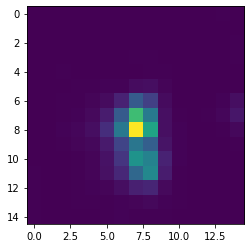

In [200]:
plt.imshow(data.tpf[0])

In [27]:
data.lite = False
vis = eleanor.Visualize(data)

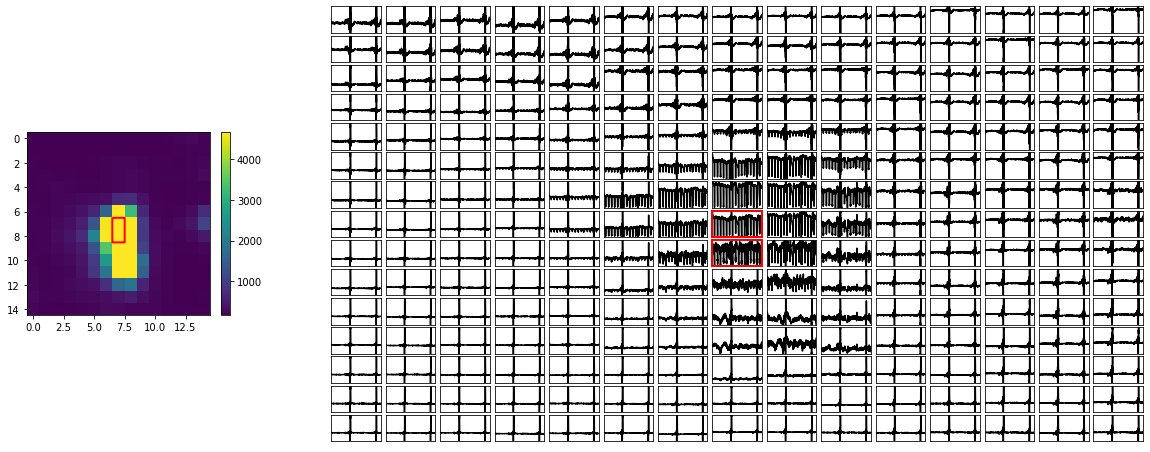

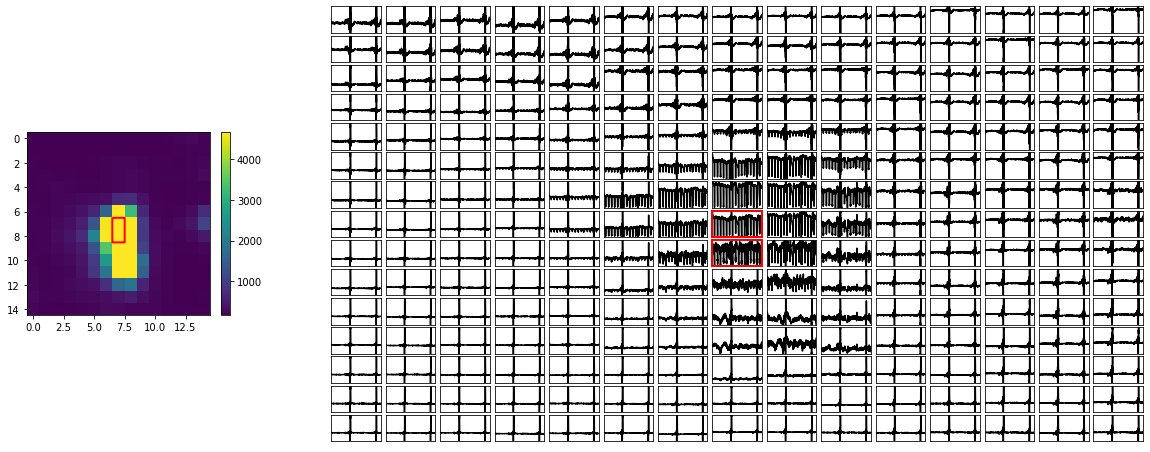

In [198]:
vis.pixel_by_pixel()

1324


<AxesSubplot:title={'center':'TIC 120362128'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

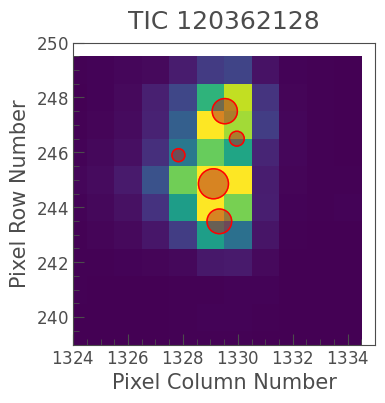

In [31]:
tic = 120362128
h, w = data.tpf.shape[1], data.tpf.shape[2]
tpf = lk.search_tesscut(f'TIC {tic}')[0].download(cutout_size=(h, w))
vis.plot_gaia_overlay(tpf=tpf, magnitude_limit=14)

In [242]:
sources = eleanor.mast.gaia_sources_in_tpf(tpf, 10)

In [110]:
fluxes = np.max(tpfs[0]) * np.ones(nstars,) # flux of each star
globalpars = np.array([0, 0, bkgs[0]]) # xshift, yshift of target star; background
optpars = model.get_default_optpars() # model-specific optimization parameters
par = np.concatenate((fluxes, globalpars, optpars))
loss = lambda mean_val, data, err, bkg: np.sum((mean_val - data) ** 2 / err)
def nll(params, data, err, bkg):
    """Negative log likelihood for an averaged PSF fit."""
    for j, p in enumerate(params):
        if not(model.bounds[j, 0] <= p and p <= model.bounds[j, 1]):
            return np.infty

    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    
    return loss(mean_val, data, err, bkg)

In [115]:
mean_pars = minimize(nll, par, (np.mean(tpfs, axis=0), np.mean(errs, axis=0), np.mean(bkgs, axis=0)), method='TNC', tol=1e-4)

In [116]:
mean_pars

     fun: 4608217.524175251
     jac: array([ 1.52165879e+02,  7.60174672e+01, -1.16964714e+02,  3.79551249e+06,
        3.84085141e+06,  8.61463385e+03,  1.92075334e+06,  3.14516016e+05,
        1.95557064e+06])
 message: 'Max. number of function evaluations reached'
    nfev: 1010
     nit: 8
  status: 3
 success: False
       x: array([ 2.39945010e+04,  5.97427716e+04,  3.22078082e+04, -3.73945069e-01,
       -3.97243777e-01,  1.66325864e+02,  8.01183370e-01, -2.02193639e-01,
        9.61359095e-01])